In [ ]:
from Automata import Automata
from utils import *

# Space Specification:

In [ ]:
#space=(x1_max, x2_max, x3_range, NX1, NX2, NX3)
space=(10, 10, (-1,1), 50, 50, 15)
#controls = (u1_min, u1_max, u2_min, u2_max, NU1, NU2)
controls = (0.25, 1, -1, 1, 3, 5)
#inputs=(w1,w2,w3,t)
inputs=(0.05,0.05,0.05,1)

# x0_min = 0,0,x3_range[0]
# x0_max = x1_m,x2_m,x3_range[1]
x0_min=(0,0,space[2][0])
x0_max=(space[0],space[1],space[2][1])

In [ ]:
def TransFunct(x,u,inputs):
  return ((x[0]+inputs[3]*(u[0]*math.cos(x[2]*math.pi)+inputs[0])),(x[1]+inputs[3]*(u[0]*math.sin(x[2]*math.pi)+inputs[1])),(x[2]+inputs[3]*(u[1]+inputs[2]/math.pi)))

def Dx(u, inputs):
  return np.array([[1, 0, inputs[3]*abs(u[0])],[0, 1, inputs[3]*abs(u[0])],[0, 0, 1]], dtype=float)
def Sx(x_min, x_max, inputs):
  return np.array([(x_max[i] - x_min[i]) / 2 for i in range(3)], dtype=float)
def Xx(x_min, x_max, inputs):
  return np.array([(x_max[i] + x_min[i]) / 2 for i in range(3)], dtype=float)

def Dw(inputs): 
  return np.array([[inputs[3], 0, 0],[0, inputs[3], 0],[0, 0, inputs[3]]], dtype=float)
def Sw(inputs):
  return np.array([inputs[i] for i in range(3)], dtype=float)
def Wx(inputs):
  return [0,0,0]


C:\Users\moham\AppData\Local\Temp\ipykernel_19644\3279472435.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)


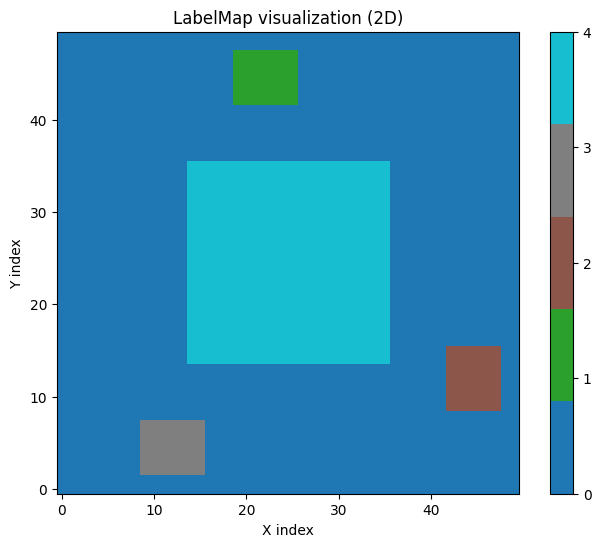

In [14]:
SpecMap = {
    'a' : {0: 'a', 1: 'b', 2: 'c', 3: 'e', 4: 'e'}, # nothing
    'b' : {0: 'b', 1: 'b', 2: 'e', 3: 'd', 4: 'e'}, # reched R1
    'c' : {0: 'c', 1: 'e', 2: 'c', 3: 'd', 4: 'e'}, # reached R2
    'd' : {0: 'e', 1: 'e', 2: 'e', 3: 'd', 4: 'e'}, # accomplished
    'e' : {0: 'e', 1: 'e', 2: 'e', 3: 'e', 4: 'e'}  # trash
}

accepting_states = ['d']
trash_states = ['e']

Rs = {
  4
  : (((3.0, 3.0, -1), (7.0, 7.0, 1)),  True),
  3: (((2.0, 0.5, -1), (3.0, 1.5, 1)), False),
  2: (((8.5, 2.0, -1), (9.5, 3.0, 1)), False),
  1: (((4.0, 8.5, -1), (5.0, 9.5, 1)), False),
}

LabelMap , default_states= build_LabelMap(space, x0_min, x0_max, Rs)

import matplotlib.pyplot as plt
import numpy as np

def plot_LabelMap_2D(LabelMap, space):
    """
    Plots a 2D grid showing the label of each cell based on the first two coordinates.
    Ignores the third dimension (z-axis).
    """
    NX1, NX2 = space[3], space[4]
    
    grid = np.zeros((NX1, NX2))  # Initialize a grid
    
    for (i, j, k), label in LabelMap.items():
        grid[i, j] = label  # Only consider first two coordinates
    
    plt.figure(figsize=(8, 6))
    cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
    im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest')
    plt.colorbar(im, ticks=np.arange(np.max(list(LabelMap.values()))+1))
    plt.xlabel('X index')
    plt.ylabel('Y index')
    plt.title('LabelMap visualization (2D)')
    plt.show()

# Call the function
plot_LabelMap_2D(LabelMap, space)

# Generation

In [ ]:
# step 1: generate the TransitionMap and define the automata
Automata = Automata(TransMap(x0_min, x0_max, controls, inputs, space, TransFunct, Dx, Dw, Sx, Sw, Xx, Wx))

In [ ]:
# 2. Build product automaton
Automata.ToProdAutomate(SpecMap, LabelMap, 'a')

In [ ]:
# 3. Define target product states
target = [(x,q) for (x,q) in Automata.TransMap.keys() if q in accepting_states]

In [ ]:
Automata.ApplyReachability(target)

In [ ]:
Automata.SaveAutomataToCsv("automata.csv")

# Visualisation

In [ ]:
# ============================================================
#   VISUALISE MULTIPLE RANDOM TRAJECTORIES WITH START/END
# ============================================================

# Number of random trajectories to generate
N_traj = 100  # (change as you want)

# Pick random starting states from start_states (system+spec)
random_starts = random.sample(start_states, N_traj)

# Prepare figure
fig, ax = plt.subplots(figsize=(6, 6))

# Draw regions R1–R4
for label, ((rmin, rmax), intersect) in Rs.items():
    xmin, ymin = rmin[0], rmin[1]
    xmax, ymax = rmax[0], rmax[1]
    width, height = xmax - xmin, ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height,
                         alpha=0.25, edgecolor='k')
    ax.add_patch(rect)
    ax.text((xmin+xmax)/2, (ymin+ymax)/2, f"R{label}",
            ha='center', va='center')

# Plot each trajectory with start/end points highlighted
for start in random_starts:
    traj_states = bfs_trajectory(ReachProd, [start], set(target))
    if traj_states is None:
        continue
    traj_centers = np.array([cell_center(s[0], space) for s in traj_states])
    
    # Plot trajectory
    ax.plot(traj_centers[:, 0], traj_centers[:, 1], '-', alpha=0.7, color='blue')
    
    # Starting point in green
    ax.plot(traj_centers[0, 0], traj_centers[0, 1], 'go', markersize=5)
    
    # Ending point in red
    ax.plot(traj_centers[-1, 0], traj_centers[-1, 1], 'ro', markersize=5)

# Final plot formatting
ax.set_xlim(0, space[0])
ax.set_ylim(0, space[1])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.grid(True)
ax.set_title(f"{N_traj} random symbolic trajectories\n(start = green, end = red)")